In [86]:
##FALTA AJUSTAAAAAAAAAAAAAR

import numpy as np
import pandas as pd
from time import time
from sklearn import datasets
from sklearn.metrics import adjusted_rand_score, silhouette_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [87]:
dataset = pd.read_csv('../data/preprocessed/SPECTF_preprocessed.csv')
dataset

,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44
0,1,59,52,70,67,73,66,72,61,58,...,66,56,62,56,72,62,74,74,64,67
1,1,72,62,69,67,78,82,74,65,69,...,65,71,63,60,69,73,67,71,56,58
2,1,71,62,70,64,67,64,79,65,70,...,73,70,66,65,64,55,61,41,51,46
3,1,69,71,70,78,61,63,67,65,59,...,61,61,66,65,72,73,68,68,59,63
4,1,70,66,61,66,61,58,69,69,72,...,67,69,70,66,70,64,60,55,49,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,0,74,69,75,70,70,74,77,77,65,...,66,67,63,61,71,68,66,65,54,57
263,0,72,61,64,66,64,59,68,66,76,...,69,64,67,71,69,68,65,73,56,52
264,0,75,73,72,77,68,67,76,73,67,...,70,67,72,71,79,75,77,75,67,71
265,0,59,62,72,74,66,66,74,76,63,...,65,71,67,69,77,78,77,76,70,70


In [88]:
x = dataset.drop(columns=['target'], axis=1)
y = dataset['target']


'''x = np.random.rand(100, 10)
y = np.random.randint(0, 2, 100)'''


'x = np.random.rand(100, 10)\ny = np.random.randint(0, 2, 100)'

In [89]:
class KFCM_K:
    def __init__(self, c, m=1.1, epochs=100, tol=1e-6, seed=0):
        # Hyperparameters
        self.m = m
        self.epochs = epochs
        self.tol = tol

        # c: number of clusters
        self.c = c

        self._zero = 1e-20
        self._rng = np.random.default_rng(seed)
        self._epoch = 0

        self._x = None
        self._y = None
        self._n = None
        self._p = None
        self._u = None
        self._u_m = None
        self._kernel = None
        self._denominator_j = None
        self._g = None
        self._j_new = None
        self._j_old = None
        return

    def fit(self, X, y=None):
        start_time = time()
        # Normalization
        scaler = MinMaxScaler()
        self._x = scaler.fit_transform(X)[:, :, np.newaxis]
        self._y = np.asarray(y)[:, np.newaxis]

        # n: number of instances
        # p: number of features
        self._n, self._p, _ = self._x.shape

        # Arrays initializations
        self._u = np.zeros((self._n, self.c, 1))

        # Prototype selection
        g_idx = self._rng.integers(0, self._n, self.c)
        self._g = self._x[g_idx]

        self._update_kernel()

        # Compute the membership degree
        self._update_u()

        # Compute the objective function
        self._update_j()

        for epoch in range(1, self.epochs + 1):
            self._epoch = epoch
            self._j_old = self._j_new

            # Update prototypes
            self._update_g()

            # Update membership degrees
            self._update_u()

            # Update the objective function
            self._update_j()
            if abs(self._j_new - self._j_old) < self.tol:
                break
        end_time = time()
        print(f"Execution time: {round((end_time - start_time) / 60, 2)} minutes")

        return

    def predict(self, X):
        return

    def evaluate(self, metric):
        metrics = {
            "accuracy": self._evaluate_accuracy,
            "MPC": self._evaluate_modified_partition_coefficient,
            "rand": self._evaluate_adjusted_rand_score,
            "error": self._evaluate_error,
        }
        metric_function = metrics.get(metric, "error")
        return metric_function()

    def _update_kernel(self):
        #"""Equation 5."""
        # Step 1: Calculate squared Euclidean distances
        squared_distances = (self._x - self._g.T) ** 2

        # Step 2: Sum across dimensions
        summed_distances = squared_distances.sum(axis=1)

        # Step 3: Apply the exponential function
        exponential = np.exp(summed_distances * (-1 / 2))
        self._kernel = exponential[:, :, np.newaxis]
        return

    def _update_u(self):
        #"""Equation 16a."""

        self._denominator_j = 2 - 2 * self._kernel
        self._denominator_j = np.maximum(self._denominator_j, self._zero)

        numerator = np.swapaxes(self._denominator_j, 1, 2)

        division = (numerator / self._denominator_j) ** (1 / (self.m - 1))

        self._u = division.sum(axis=1) ** -1
        self._u = self._u[:, :, np.newaxis]

        self._u_m = self._u**self.m
        self._u_m_kernel = self._u_m * self._kernel
        return

    def _update_j(self):
        """Equation 11."""
        self._j_new = (self._u_m * self._denominator_j).sum()
        print(f"Epoch: {self._epoch:03d} | Objective function J: {self._j_new:.8f}")
        return

    def _update_g(self):
        """Equation 15a."""
        x = np.swapaxes(self._x, 1, 2)

        numerator = (self._u_m_kernel * x).sum(axis=0)

        denominator = self._u_m_kernel.sum(axis=0)

        self._g = (numerator / denominator)[:, :, np.newaxis]

        self._update_kernel()
        return

    def _evaluate_accuracy(self):
        pred = np.argmax(self._u, axis=1)
        y_with_pred = pd.DataFrame(np.concatenate((self._y, pred), axis=1))
        y_with_pred["value"] = 1
        pivot_table = pd.pivot_table(
            y_with_pred, columns=[0], index=[1], values="value", aggfunc="sum"
        )
        pivot_table = pivot_table.fillna(0).values

        n_i = pivot_table.sum(axis=1)[:, np.newaxis]
        p_ij = pivot_table / n_i
        p_i = p_ij.max(axis=1)[:, np.newaxis]
        acc = (n_i * p_i).sum(axis=0) / self._n
        return acc[0]

    def _evaluate_modified_partition_coefficient(self):
        pc = np.sum(self._u**2) / self._n
        mpc = 1 - (self.c / (self.c - 1)) * (1 - pc)
        return mpc

    def _evaluate_adjusted_rand_score(self):
        y_pred = np.argmax(self._u, axis=1)
        return adjusted_rand_score(self._y[:, 0], y_pred[:, 0])

    def _evaluate_error(self):
        raise ValueError("Metric not implemented")


In [90]:
class KFCM_K_W_1:
    def __init__(self, c, m=1.1, epochs=100, tol=1e-6, seed=0):
        # Hyperparameters
        self.m = m
        self.epochs = epochs
        self.tol = tol

        # c: number of clusters
        self.c = c

        self._zero = 1e-20
        self._rng = np.random.default_rng(seed)
        self._epoch = 0

        self._x = None
        self._y = None
        self._n = None
        self._p = None
        self._s = None
        self._u = None
        self._u_m = None
        self._u_m_kernel = None
        self._kernel = None
        self._denominator_j = None
        self._g = None
        self._j_new = None
        self._j_old = None
        return

    def fit(self, X, y=None):
        start_time = time()
        # Normalization
        scaler = MinMaxScaler()
        self._x = scaler.fit_transform(X)[:, :, np.newaxis]
        self._y = np.asarray(y)[:, np.newaxis]

        # n: number of instances
        # p: number of features
        self._n, self._p, _ = self._x.shape

        # Arrays initializations
        # s: array of width parameters 1/s^2, from Step 7
        self._s = np.ones((1,self._p))
        self._u = np.zeros((self._n, self.c, 1))

        # Prototype selection, Step 8
        g_idx = self._rng.integers(0, self._n, self.c)
        self._g = self._x[g_idx]

        self._update_kernel()

        # Compute the membership degree, Step 9,21
        self._update_u()

		# Compute the objective function, Step 11,23
        self._update_j()

        for epoch in range(1, self.epochs + 1):
            self._epoch = epoch
            # Step 13
            self._j_old = self._j_new

            # Step 15
            self._update_s()

            # Step 18
            self._update_g()

            # Step 21
            self._update_u()

            # Step 23
            #if the absolute difference between self._j_new and self._j_old is
            # less than self.tol, the loop will break
            self._update_j()
            if abs(self._j_new - self._j_old) < self.tol:
                break
        end_time = time()
        print(f"Execution time: {round((end_time - start_time) / 60, 2)} minutes")

        return

    def predict(self, X):
        return

    def evaluate(self, metric):
        metrics = {
            "accuracy": self._evaluate_accuracy,
            "MPC": self._evaluate_modified_partition_coefficient,
            "rand": self._evaluate_adjusted_rand_score,
            "error": self._evaluate_error,
        }
        metric_function = metrics.get(metric, "error")
        return metric_function()

    def _update_kernel(self):
        """Equation 10."""
        # Step 1: Calculate squared Euclidean distances
        squared_distances = (self._x - self._g.T) ** 2

        # Step 2: Apply weights
        weighted_distances = squared_distances * self._s.T

        # Step 3: Sum across dimensions
        summed_distances = weighted_distances.sum(axis=1)

        # Step 4: Apply the exponential function
        exponential = np.exp(summed_distances * (-1 / 2))
        self._kernel = exponential[:, :, np.newaxis]
        return

    def _update_u(self):
        """Equation 16a."""

        self._denominator_j = 2 - 2 * self._kernel
        self._denominator_j = np.maximum(self._denominator_j, self._zero)

        numerator = np.swapaxes(self._denominator_j, 1, 2)

        division = (numerator / self._denominator_j) ** (1 / (self.m - 1))

        self._u = division.sum(axis=1) ** -1
        self._u = self._u[:, :, np.newaxis]

        self._u_m = self._u**self.m
        self._u_m_kernel = self._u_m * self._kernel
        return

    def _update_j(self):
        """Equation 11."""
        self._j_new = (self._u_m * self._denominator_j).sum()
        print(f"Epoch: {self._epoch:03d} | Objective function J: {self._j_new:.8f}")
        return

    def _update_s(self):
        """Equation 14a."""
        squared_distances = (self._x - self._g.T) ** 2

        squared_distances = np.swapaxes(squared_distances, 1, 2)

        denominator = (self._u_m_kernel * squared_distances).sum(axis=0)[:, :, np.newaxis]
        
        denominator = (denominator).sum(axis=2)[:, :, np.newaxis] # Linha nova

        denominator = np.log(denominator)

        numerator = denominator.sum(axis=1)[:, :, np.newaxis] * self._p**-1

        subtracted = numerator - denominator

        self._s = np.exp(subtracted)

        self._update_kernel()
        return

    def _update_g(self):
        """Equation 15a."""
        x = np.swapaxes(self._x, 1, 2)

        numerator = (self._u_m_kernel * x).sum(axis=0)

        denominator = self._u_m_kernel.sum(axis=0)

        self._g = (numerator / denominator)[:, :, np.newaxis]

        self._update_kernel()
        return

    def _evaluate_accuracy(self):
        pred = np.argmax(self._u, axis=1)
        y_with_pred = pd.DataFrame(np.concatenate((self._y, pred), axis=1))
        y_with_pred["value"] = 1
        pivot_table = pd.pivot_table(
            y_with_pred, columns=[0], index=[1], values="value", aggfunc="sum"
        )
        pivot_table = pivot_table.fillna(0).values

        n_i = pivot_table.sum(axis=1)[:, np.newaxis]
        p_ij = pivot_table / n_i
        p_i = p_ij.max(axis=1)[:, np.newaxis]
        acc = (n_i * p_i).sum(axis=0) / self._n
        return acc[0]

    def _evaluate_modified_partition_coefficient(self):
        pc = np.sum(self._u**2) / self._n
        mpc = 1 - (self.c / (self.c - 1)) * (1 - pc)
        return mpc

    def _evaluate_adjusted_rand_score(self):
        y_pred = np.argmax(self._u, axis=1)
        return adjusted_rand_score(self._y[:, 0], y_pred[:, 0])

    def _evaluate_error(self):
        raise ValueError("Metric not implemented")

In [91]:
'''u3 = []
g3 = []
j3 = []
acc_vec3 = []
mpc_vec3 = []
rand_vec3 = []

print("m = 1.1\n")
c_values = [2,3,4,5]

for c in c_values:
    for run in range(50):
        model = KFCM_K(c=c, m=1.1, epochs=100, tol=1e-6, seed=run)
        model.fit(x, y)
        
        print(f"\nRun: {run+1}")
        
        acc = model.evaluate(metric="accuracy")
        print(f"Accuracy: {acc:.04f}")
        
        mpc = model.evaluate(metric="MPC")
        print(f"MPC: {mpc:.04f}")
        
        adjusted_rand_score_value = model.evaluate(metric="rand")
        print(f"Adjusted Rand Score: {adjusted_rand_score_value:.04f}\n")
        
        u3.append(model._u.reshape(267, c))
        g3.append(model._g.reshape(c, 44))
        j3.append(model._j_new)
        acc_vec3.append(acc)
        mpc_vec3.append(mpc)
        rand_vec3.append(adjusted_rand_score_value)'''


'u3 = []\ng3 = []\nj3 = []\nacc_vec3 = []\nmpc_vec3 = []\nrand_vec3 = []\n\nprint("m = 1.1\n")\nc_values = [2,3,4,5]\n\nfor c in c_values:\n    for run in range(50):\n        model = KFCM_K(c=c, m=1.1, epochs=100, tol=1e-6, seed=run)\n        model.fit(x, y)\n        \n        print(f"\nRun: {run+1}")\n        \n        acc = model.evaluate(metric="accuracy")\n        print(f"Accuracy: {acc:.04f}")\n        \n        mpc = model.evaluate(metric="MPC")\n        print(f"MPC: {mpc:.04f}")\n        \n        adjusted_rand_score_value = model.evaluate(metric="rand")\n        print(f"Adjusted Rand Score: {adjusted_rand_score_value:.04f}\n")\n        \n        u3.append(model._u.reshape(267, c))\n        g3.append(model._g.reshape(c, 44))\n        j3.append(model._j_new)\n        acc_vec3.append(acc)\n        mpc_vec3.append(mpc)\n        rand_vec3.append(adjusted_rand_score_value)'

In [92]:
'''u3 = []
g3 = []
s3 = []
j3 = []
acc_vec3 = []
mpc_vec3 = []
rand_vec3 = []
print("m = 1.1\n")
c_values = [2,3,4,5]
for c in c_values:
    for run in range(50):
        model = KFCM_K_W_1(c=c, m=1.1, epochs=100,tol=1e-6, seed=run)
        model.fit(x,y)
        print(f"\nRun: {run+1}")
        acc = model.evaluate(metric="accuracy")
        print(f"Accuracy: {acc:.04f}")
        mpc = model.evaluate(metric="MPC")
        print(f"MPC: {mpc:.04f}")
        adjusted_rand_score_value = model.evaluate(metric="rand")
        print(f"Adjusted Rand Score: {adjusted_rand_score_value:.04f}\n")
        u3.append(model._u.reshape(267, c))
        g3.append(model._g.reshape(c, 44))
        s3.append(model._s.reshape(c, 44))
        j3.append(model._j_new)
        acc_vec3.append(acc)
        mpc_vec3.append(mpc)
        rand_vec3.append(adjusted_rand_score_value)'''

'u3 = []\ng3 = []\ns3 = []\nj3 = []\nacc_vec3 = []\nmpc_vec3 = []\nrand_vec3 = []\nprint("m = 1.1\n")\nc_values = [2,3,4,5]\nfor c in c_values:\n    for run in range(50):\n        model = KFCM_K_W_1(c=c, m=1.1, epochs=100,tol=1e-6, seed=run)\n        model.fit(x,y)\n        print(f"\nRun: {run+1}")\n        acc = model.evaluate(metric="accuracy")\n        print(f"Accuracy: {acc:.04f}")\n        mpc = model.evaluate(metric="MPC")\n        print(f"MPC: {mpc:.04f}")\n        adjusted_rand_score_value = model.evaluate(metric="rand")\n        print(f"Adjusted Rand Score: {adjusted_rand_score_value:.04f}\n")\n        u3.append(model._u.reshape(267, c))\n        g3.append(model._g.reshape(c, 44))\n        s3.append(model._s.reshape(c, 44))\n        j3.append(model._j_new)\n        acc_vec3.append(acc)\n        mpc_vec3.append(mpc)\n        rand_vec3.append(adjusted_rand_score_value)'

Running KFCM-K...
Epoch: 000 | Objective function J: 267.64880441
Epoch: 001 | Objective function J: 159.69755538
Epoch: 002 | Objective function J: 155.92925331
Epoch: 003 | Objective function J: 151.06368860
Epoch: 004 | Objective function J: 148.26121997
Epoch: 005 | Objective function J: 147.70528401
Epoch: 006 | Objective function J: 147.60506538
Epoch: 007 | Objective function J: 147.56982850
Epoch: 008 | Objective function J: 147.55007244
Epoch: 009 | Objective function J: 147.53754232
Epoch: 010 | Objective function J: 147.52953062
Epoch: 011 | Objective function J: 147.52447554
Epoch: 012 | Objective function J: 147.52132834
Epoch: 013 | Objective function J: 147.51938864
Epoch: 014 | Objective function J: 147.51820161
Epoch: 015 | Objective function J: 147.51747877
Epoch: 016 | Objective function J: 147.51704010
Epoch: 017 | Objective function J: 147.51677453
Epoch: 018 | Objective function J: 147.51661403
Epoch: 019 | Objective function J: 147.51651716
Epoch: 020 | Objective

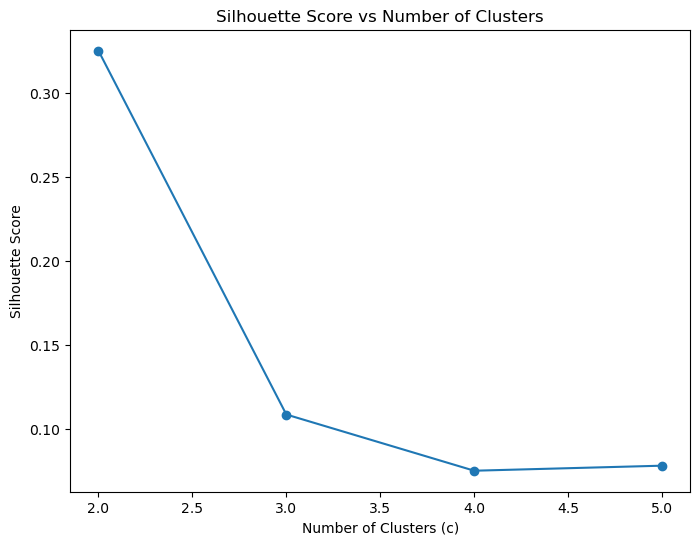

Running KFCM-K-W.1...
Epoch: 000 | Objective function J: 267.64880441
Epoch: 001 | Objective function J: 163.28613628
Epoch: 002 | Objective function J: 147.95875359
Epoch: 003 | Objective function J: 145.77246695
Epoch: 004 | Objective function J: 143.41683924
Epoch: 005 | Objective function J: 141.68615307
Epoch: 006 | Objective function J: 140.97155853
Epoch: 007 | Objective function J: 140.75616934
Epoch: 008 | Objective function J: 140.66367426
Epoch: 009 | Objective function J: 140.59710969
Epoch: 010 | Objective function J: 140.53999805
Epoch: 011 | Objective function J: 140.49121125
Epoch: 012 | Objective function J: 140.45147396
Epoch: 013 | Objective function J: 140.42038596
Epoch: 014 | Objective function J: 140.39668173
Epoch: 015 | Objective function J: 140.37906657
Epoch: 016 | Objective function J: 140.36636043
Epoch: 017 | Objective function J: 140.35743165
Epoch: 018 | Objective function J: 140.35127256
Epoch: 019 | Objective function J: 140.34707653
Epoch: 020 | Objec

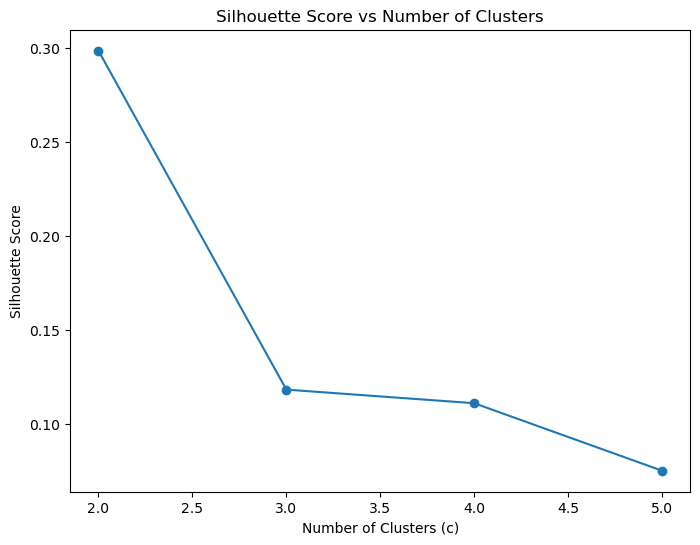

Best c for KFCM-K: 2
Modified Partition Coefficient for KFCM-K: 0.8294130733396028
Adjusted Rand Score for KFCM-K: -0.05585211767703252
Best c for KFCM-K-W.1: 2
Modified Partition Coefficient for KFCM-K-W.1: 0.816064656287997
Adjusted Rand Score for KFCM-K-W.1: -0.04190448864415141


In [93]:
def run_experiments(algorithm_class, x, y, c_values, m=1.1, epochs=100, tol=1e-6):
    results = {
        'best_fuzzy_partitions': {},
        'best_objective_functions': {},
        'best_crisp_partitions': {},
        'sil_scores': {},
        'modified_partition_coefficient': {},
        'adjusted_rand_scores': {},
        'prototypes': {},
        'width_parameters': {},
        'objective_function_history': {}
    }

    for c in c_values:
        best_j = float('inf')
        best_model = None
        best_u = None

        for run in range(50):
            model = algorithm_class(c=c, m=m, epochs=epochs, tol=tol, seed=run)
            model.fit(x, y)

            if model._j_new < best_j:
                best_j = model._j_new
                best_model = model
                best_u = model._u

        results['best_fuzzy_partitions'][c] = best_u
        results['best_objective_functions'][c] = best_j

        # Convert fuzzy partition to crisp partition
        crisp_partition = np.argmax(best_u, axis=1).flatten()
        results['best_crisp_partitions'][c] = crisp_partition

        # Calculate silhouette score
        sil_score = silhouette_score(x, crisp_partition)
        results['sil_scores'][c] = sil_score

        # Calculate Modified Partition Coefficient
        mpc = best_model._evaluate_modified_partition_coefficient()
        results['modified_partition_coefficient'][c] = mpc

        # Calculate Adjusted Rand Score
        ars = adjusted_rand_score(y.to_numpy().flatten(), crisp_partition)
        results['adjusted_rand_scores'][c] = ars

        # Store prototypes
        results['prototypes'][c] = best_model._g

        if hasattr(best_model, '_s'):
            # Store width parameters (for KFCM-K-W.1)
            results['width_parameters'][c] = best_model._s

        # Store objective function history
        results['objective_function_history'][c] = [model._j_old, model._j_new]

    return results

def plot_silhouette_scores(results):
    c_values = list(results['sil_scores'].keys())
    sil_scores = [results['sil_scores'][c] for c in c_values]

    plt.figure(figsize=(8, 6))
    plt.plot(c_values, sil_scores, marker='o')
    plt.xlabel('Number of Clusters (c)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.show()

# Execute experiments for both algorithms
c_values = [2, 3, 4, 5]

print("Running KFCM-K...")
results_kfcm_k = run_experiments(KFCM_K, x, y, c_values)
plot_silhouette_scores(results_kfcm_k)
best_c_kfcm_k = max(results_kfcm_k['sil_scores'], key=results_kfcm_k['sil_scores'].get)

print("Running KFCM-K-W.1...")
results_kfcm_k_w_1 = run_experiments(KFCM_K_W_1, x, y, c_values)
plot_silhouette_scores(results_kfcm_k_w_1)
best_c_kfcm_k_w_1 = max(results_kfcm_k_w_1['sil_scores'], key=results_kfcm_k_w_1['sil_scores'].get)

# Print results for best partitions
print(f"Best c for KFCM-K: {best_c_kfcm_k}")
print(f"Modified Partition Coefficient for KFCM-K: {results_kfcm_k['modified_partition_coefficient'][best_c_kfcm_k]}")
print(f"Adjusted Rand Score for KFCM-K: {results_kfcm_k['adjusted_rand_scores'][best_c_kfcm_k]}")

print(f"Best c for KFCM-K-W.1: {best_c_kfcm_k_w_1}")
print(f"Modified Partition Coefficient for KFCM-K-W.1: {results_kfcm_k_w_1['modified_partition_coefficient'][best_c_kfcm_k_w_1]}")
print(f"Adjusted Rand Score for KFCM-K-W.1: {results_kfcm_k_w_1['adjusted_rand_scores'][best_c_kfcm_k_w_1]}")




In [94]:
#Desenvolver melhor
def plot_prototypes(prototypes, title='Prototypes'):
    plt.figure(figsize=(10, 6))
    for i, prototype in enumerate(prototypes):
        plt.plot(prototype, label=f'Cluster {i+1}')
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

def plot_objective_function_history(history, title='Objective Function History'):
    plt.figure(figsize=(10, 6))
    plt.plot(history, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
    plt.title(title)
    plt.show()

